In [59]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
#Importing dataframes, where df is all combined, df1 is print, df2 is print 2,..
df = pd.read_csv("df.csv") 
df1 = pd.read_csv("df1.csv")
df2 = pd.read_csv("df2.csv")
df3 = pd.read_csv("df3.csv")

# Investigating acquisition time delays

In [61]:
df[['timetime', 'timeperf_counter']].describe().style.set_caption("Prusa acquisition delays").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '15px')
    ]
}])

,timetime,timeperf_counter
count,23427.000000,23427.000000
mean,0.310466,0.312333
std,0.032461,0.032271
min,0.242305,0.244564
25%,0.297299,0.299237
50%,0.306159,0.307873
75%,0.317771,0.319541
max,3.481807,3.482454


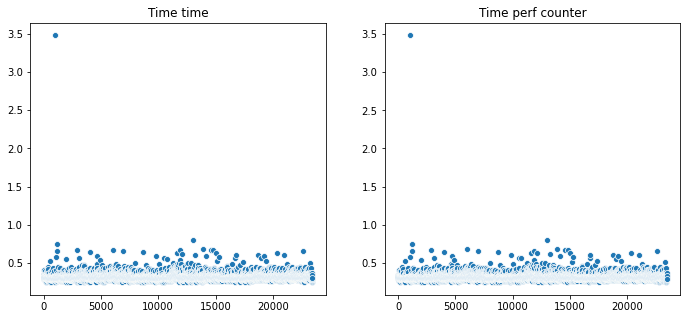

In [62]:
#Scatterplot of timetime and timeperf_counter
fig = plt.figure(figsize = (18,5))

ax1 = plt.subplot(1,3,1)
sns.scatterplot(data=df['timetime'])
ax1.title.set_text('Time time')

ax2 = plt.subplot(1,3,2)
ax2.title.set_text('Time perf counter')
sns.scatterplot(data=df['timeperf_counter'])

In [63]:
#Investigating difference between Time time and Time perf counter
df_delays = df[['timetime', 'timeperf_counter']]
df_delays = df_delays.assign(Delay_difference = df_delays['timetime'] - df['timeperf_counter'])
df_delays.describe()



,timetime,timeperf_counter,Delay_difference
count,23427.000000,23427.000000,23427.000000
mean,0.310466,0.312333,-0.001867
std,0.032461,0.032271,0.002907
min,0.242305,0.244564,-0.015501
25%,0.297299,0.299237,-0.000837
50%,0.306159,0.307873,-0.000587
75%,0.317771,0.319541,-0.000424
max,3.481807,3.482454,0.006359


In [64]:
#Selecting only timeperf_counter
df[['timeperf_counter']].describe().style.set_caption("Prusa").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '20px')
    ]
}])

,timeperf_counter
count,23427.000000
mean,0.312333
std,0.032271
min,0.244564
25%,0.299237
50%,0.307873
75%,0.319541
max,3.482454


# Investigating Temperature variaiton

In [65]:
df[['Hot_end_temperature','Build_platform_temperature']].describe()

,Hot_end_temperature,Build_platform_temperature
count,23427.000000,23427.000000
mean,199.978678,60.014184
std,0.374475,0.121689
min,194.600000,59.300000
25%,199.800000,60.000000
50%,200.000000,60.000000
75%,200.200000,60.100000
max,201.600000,61.500000


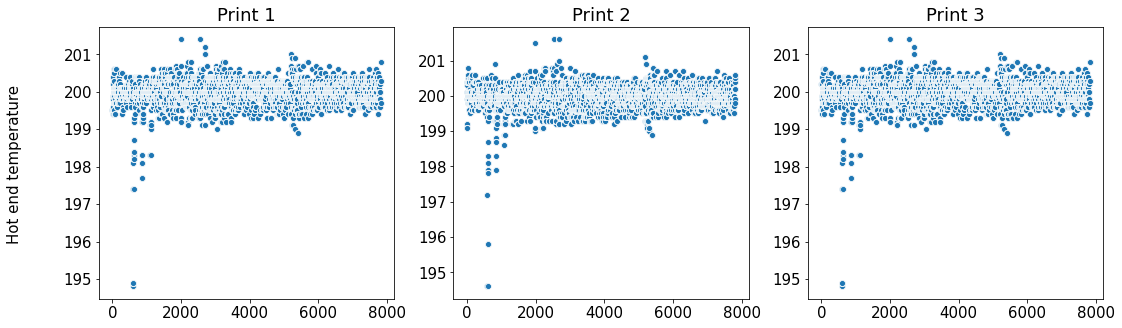

In [92]:
#Ploting scatterplot of hot end  temperature for each print 
fig = plt.figure(figsize = (18,5))

#Row, Column,plot number
#Coutplot
ax1 = plt.subplot(1,3,1)
sns.scatterplot(data=df1['Hot_end_temperature'])
ax1.title.set_text('Print 1')

ax2 = plt.subplot(1,3,2)
ax2.title.set_text('Print 2')
sns.scatterplot(data=df2['Hot_end_temperature'])

ax3 = plt.subplot(1,3,3)
ax3.title.set_text('Print 3')
sns.scatterplot(data=df3['Hot_end_temperature'])

fig.text(0.5, 0.04, '', ha='center', va='center')
fig.text(0.06, 0.5, 'Hot end temperature', ha='center', va='center', rotation='vertical')
plt.rcParams["font.size"] = "15"

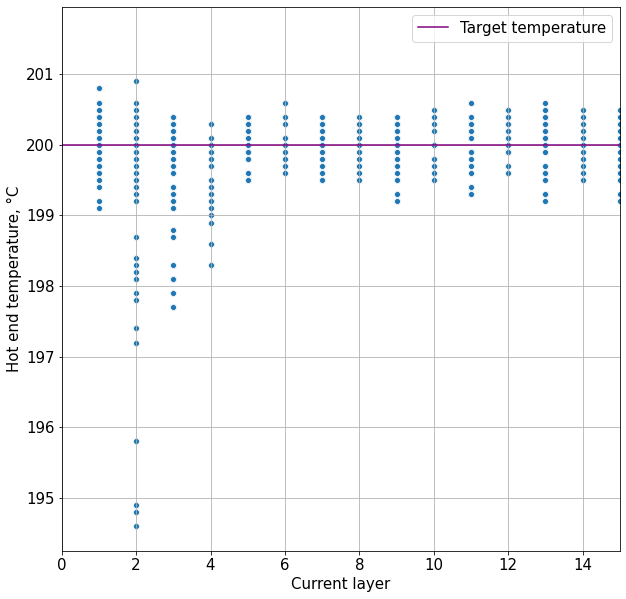

In [93]:
#Scatterplot which looks closer into hot end temperature drops during layer process

fig, ax = plt.subplots(1, figsize=(10, 10))
sns.scatterplot( x = 'Current_layer', y = 'Hot_end_temperature', data = df)
ax.axhline(df['Hot_end_target_temperature'][0], color='purple', label='Target temperature')
legend = plt.legend(loc ='upper right')
ax.set_xlim(left=0, right=15)
legend.set_zorder(3)
ax.set(xlabel ="Current layer", ylabel = "Hot end temperature, \xb0C")
#plt.style.use("dark_background")
plt.grid()
  
plt.show()

In [94]:
#Investigating where the temperature dropped to bellow 196°C
df[['Hot_end_temperature','Current_layer','Part']][df['Hot_end_temperature'] <196]

,Hot_end_temperature,Current_layer,Part
1210,194.8,2,3
1211,194.8,2,1
1212,194.8,2,3
1213,194.8,2,1
1214,194.8,2,3
1215,194.8,2,1
1216,194.8,2,1
1217,194.8,2,3
1218,194.9,2,3
1219,194.9,2,1


In [95]:

#Function uses time from "Date" to convert to process time 
def process_time(df):
    df['Date'] = pd.to_datetime(df['Date'])

    #Create column of process time based on date time
    df['Process_time_new'] = df['Date'].iloc[-1] - df['Date'].shift()
    df['Process_time_new'] = df['Process_time_new'].fillna(pd.Timedelta(seconds=0))
    df['Process_time_new'] = df['Process_time_new'].dt.seconds

    #Invert column so time start from 0
    df.Process_time_new = df.Process_time_new.values[::-1]
    
process_time(df1)
process_time(df2)
process_time(df3)


#Merge data frames and generate new indexes
data_frames = [df1, df2, df3]

df = pd.concat(data_frames,ignore_index=True)

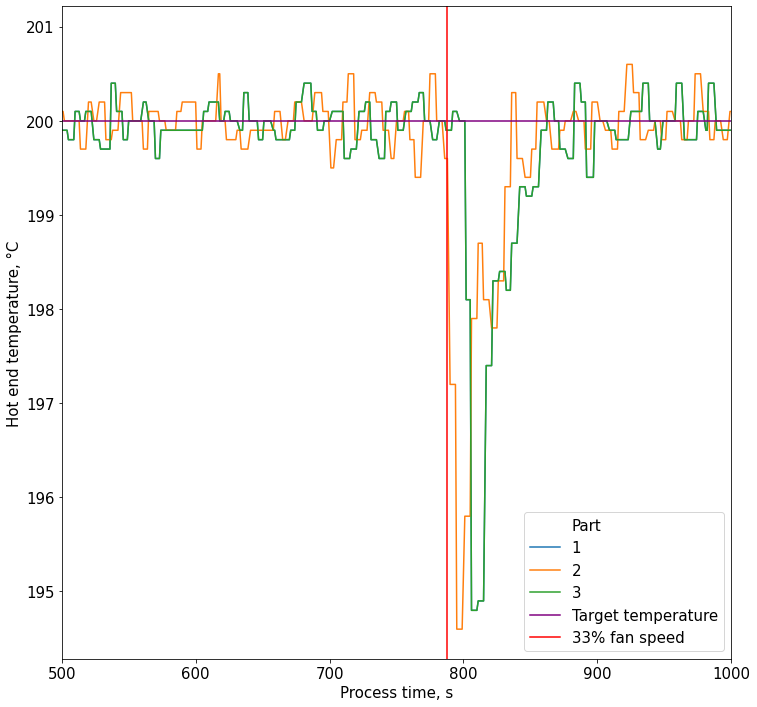

In [102]:
#We can see from hot end scatter plot that highest and lowest hot end temperature values occur during the start of the print 
#Lineplot of hot end temperature around second layer
df_new = df[df['Current_layer'] <=2]

fig, ax = plt.subplots(1, figsize=(12, 12))
sns.lineplot(data=df_new, x='Process_time_new', y="Hot_end_temperature", hue="Part", ci=None, palette=["C0", "C1", "C2"])
ax.axhline(df_new.iloc[0]['Hot_end_target_temperature'], color='purple', label='Target temperature')
#Identifying index of where second layer started on each print
f_1 = (df1['Current_layer'] == 2).idxmax()
f_2 = (df2['Current_layer'] == 2).idxmax()
f_3 = (df3['Current_layer'] == 2).idxmax()

#Finding process time of where second layer started based on the index for each print
f_1 = df1['Process_time_new'].loc[f_1]
f_2 = df1['Process_time_new'].loc[f_2]
f_3 = df1['Process_time_new'].loc[f_3]

#Selecting the average value of when second layer started and fan speed went from 0 to 33%
average_process_time = (f_1 + f_2 + f_3)/3

ax.axvline(average_process_time, color='red', label='33% fan speed')
ax.set_xlim(left=500, right=1000)
legend = plt.legend(loc ='lower right')
legend.set_zorder(3)
ax.set(xlabel ="Process time, s", ylabel = "Hot end temperature, \xb0C")

plt.show()

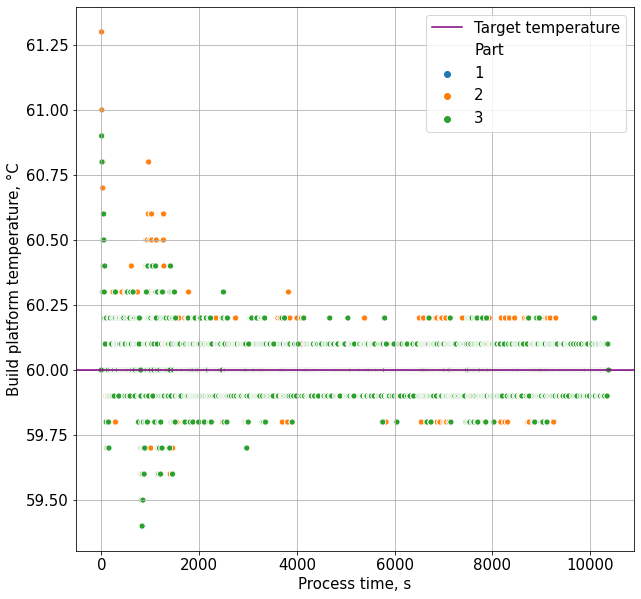

In [106]:
#Scatterplot of build platform temperature of each print 

fig, ax = plt.subplots(1, figsize=(10, 10))
sns.scatterplot( x = 'Process_time_new', y = 'Build_platform_temperature', data = df, hue = 'Part', palette=["C0", "C1", "C2"])
ax.axhline(df['Build_platform_target_temperature'][0], color='purple', label='Target temperature')
legend = plt.legend(loc ='upper right')

legend.set_zorder(3)
ax.set(xlabel ="Process time, s", ylabel = "Build platform temperature, \xb0C")
plt.grid()
  
plt.show()

In [74]:
#Comparing print data such as hot end temperature, build platform, and process time for CMM data.

Parts = {'Part1': [df1.Process_time.max(),
                  df1.Hot_end_temperature.mean(),
                  df1.Hot_end_temperature.min(),
                  df1.Hot_end_temperature.max(),
                  df1.Hot_end_temperature.std(),
                  df1.Build_platform_temperature.min(),
                  df1.Build_platform_temperature.max(),
                  df1.Build_platform_temperature.std()],
        'Part2': [df2.Process_time.max(),
                  df2.Hot_end_temperature.mean(),
                  df2.Hot_end_temperature.min(),
                  df2.Hot_end_temperature.max(),
                  df2.Hot_end_temperature.std(),
                  df2.Build_platform_temperature.min(),
                  df2.Build_platform_temperature.max(),
                  df2.Build_platform_temperature.std()],
        'Part3':[df3.Process_time.max(),
                 df3.Hot_end_temperature.mean(),
                  df3.Hot_end_temperature.min(),
                  df3.Hot_end_temperature.max(),
                  df3.Hot_end_temperature.std(),
                  df3.Build_platform_temperature.min(),
                  df3.Build_platform_temperature.max(),
                  df3.Build_platform_temperature.std()],
        }


df_cmm = pd.DataFrame(Parts, columns = ['Part1','Part2','Part3'], index=['Total process time (s)',
                                                                    'Hot end temperature\xb0C mean',
                                                                    'Hot end temperature\xb0C min',
                                                                    'Hot end temperature\xb0C max',
                                                                    'Hot end temperature\xb0C std',
                                                                    'Build platform temperature\xb0C max',
                                                                    'Build platform temperature\xb0C min',
                                                                   'Build platform temperature\xb0C std'])

#Option to change which shows only 2 decimals
pd.options.display.float_format = '{:,.2f}'.format
df_cmm.style.set_caption("Prusa").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '20px')
    ]
}])

,Part1,Part2,Part3
Total process time (s),10460.000000,10481.000000,10495.000000
Hot end temperature°C mean,199.978133,199.975692,199.982216
Hot end temperature°C min,194.800000,194.600000,194.800000
Hot end temperature°C max,201.400000,201.600000,201.600000
Hot end temperature°C std,0.372731,0.377690,0.373003
Build platform temperature°C max,59.400000,59.500000,59.300000
Build platform temperature°C min,60.900000,61.300000,61.500000
Build platform temperature°C std,0.109405,0.124488,0.130159
